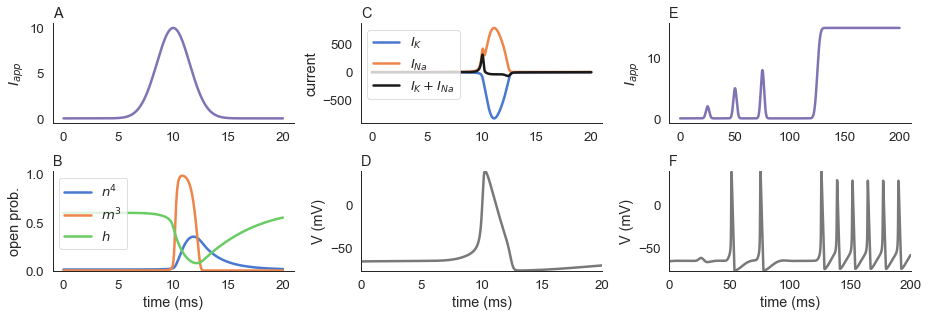

In [1]:

###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
#matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

# Keep this set to false unless you want to save figures and data
# (in which case you'll need to change some directories below)
SaveFigures=False
###############################################
###############################################



# Discretized time
T=20
dt=.001
time=np.arange(0,T,dt)

# Initialize applied current
Iapp=np.zeros_like(time)

# Add pulsatile input in the form of a Gaussian
PulseWidth=1.5 # Width of pulse in ms
PulseTime=10  # Pulse time
PulseStrength=10  # Pulse strength
Iapp=Iapp+PulseStrength*np.exp(-(time-PulseTime)**2/(2*PulseWidth**2)) 



# Define gating variables as inline functions
alphan = lambda V: .01*(V+55)/(1-np.exp(-.1*(V+55)))
betan = lambda V: .125*np.exp(-.0125*(V+65))
alpham = lambda V: .1*(V+40)/(1-np.exp(-.1*(V+40)))
betam = lambda V: 4*np.exp(-.0556*(V+65))
alphah = lambda V: .07*np.exp(-.05*(V+65))
betah = lambda V: 1/(1+np.exp(-.1*(V+35)))


# n variable
ninfty= lambda V: (alphan(V)/(alphan(V)+betan(V))) 
taun= lambda V: (1/(alphan(V)+betan(V))) 
minfty= lambda V: (alpham(V)/(alpham(V)+betam(V))) 
taum= lambda V: (1/(alpham(V)+betam(V))) 
hinfty= lambda V: (alphah(V)/(alphah(V)+betah(V))) 
tauh= lambda V: (1/(alphah(V)+betah(V))) 

# Parameters
Cm=1 
gL=.3 
EL=-54.387 
gK=36 
EK=-77 
gNa=120 
ENa=50 

# Initial conditions near their fixed points when Iapp=0
n0=0.3177     
m0=0.0530 
h0=0.5960 
V0=-65.5 

# Currents
IL= lambda V: (-gL*(V-EL)) 
IK = lambda n,V: (-gK*n **4*(V-EK)) 
INa = lambda m,h,V: (-gNa*m **3*h*(V-ENa)) 

# Toal ion currents
Iion = lambda n,m,h,V: IL(V)+IK(n,V)+INa(m,h,V)

# Euler solver
V=np.zeros_like(time) 
n=np.zeros_like(time) 
m=np.zeros_like(time) 
h=np.zeros_like(time) 
V[0]=V0 
n[0]=n0 
m[0]=m0 
h[0]=h0 
for i in range(len(time)-1):    
    # Update gating variables
    n[i+1]=n[i]+dt*((1-n[i])*alphan(V[i])-n[i]*betan(V[i])) 
    m[i+1]=m[i]+dt*((1-m[i])*alpham(V[i])-m[i]*betam(V[i])) 
    h[i+1]=h[i]+dt*((1-h[i])*alphah(V[i])-h[i]*betah(V[i])) 

    # Update membrane potential
    V[i+1]=V[i]+dt*(Iion(n[i],m[i],h[i],V[i])+Iapp[i])/Cm 


# Make figure
plt.subplots(figsize=(13,4.5))




# Make plots

plt.subplot(2,3,1)
plt.plot(time,Iapp,'m')
plt.ylabel(r'$I_{app}$')
plt.title('A',loc='left')
sns.despine()


plt.subplot(2,3,4)
plt.plot(time,n**4,label=r'$n^4$')
plt.plot(time,m**3,label=r'$m^3$')
plt.plot(time,h,label=r'$h$')
plt.legend(loc='upper left') 
plt.ylabel('open prob.')
plt.xlabel('time (ms)')
plt.ylim(bottom=0)
plt.title('B',loc='left')
sns.despine()

plt.subplot(2,3,2)
plt.plot(time,IK(n,V),label=r'$I_K$')
plt.plot(time,INa(m,h,V),label=r'$I_{Na}$')
plt.plot(time,IK(n,V)+INa(m,h,V),'k',label=r'$I_K+I_{Na}$')
plt.legend(loc='upper left')
plt.ylabel('current')
plt.title('C',loc='left')
sns.despine()


plt.subplot(2,3,5)
plt.plot(time,V,color=sns.color_palette()[7])
plt.ylabel('V (mV)')
plt.xlabel('time (ms)')
plt.axis([0,T,np.min((-70,np.min(V))),np.max((-57,np.max(V)))])
plt.title('D',loc='left')
sns.despine()



########
# Now a simulation with several spikes
########

# Discretized time
T=200
dt=.001
time=np.arange(0,T,dt)

# Initialize applied current
Iapp=np.zeros_like(time)

# Add pulsatile inputs
PulseWidths=1.5 # Width of pulse in ms
PulseTimes=[25, 50, 75]  # Pulse times
PulseStrengths=[2, 5, 8]  # Pulse strengths
for i in range(len(PulseTimes)):
    Iapp+=PulseStrengths[i]*np.exp(-(time-PulseTimes[i])**2/(2*PulseWidths**2)) 


# Add step input
from scipy.stats import norm
StepStrength=15 
StepTime=125 
StepWidth=2 
Iapp=Iapp+StepStrength*norm.cdf(time,StepTime,StepWidth) 


# Euler solver
V=np.zeros_like(time) 
n=np.zeros_like(time) 
m=np.zeros_like(time) 
h=np.zeros_like(time) 
V[0]=V0 
n[0]=n0 
m[0]=m0 
h[0]=h0 
for i in range(len(time)-1):    
    # Update gating variables
    n[i+1]=n[i]+dt*((1-n[i])*alphan(V[i])-n[i]*betan(V[i])) 
    m[i+1]=m[i]+dt*((1-m[i])*alpham(V[i])-m[i]*betam(V[i])) 
    h[i+1]=h[i]+dt*((1-h[i])*alphah(V[i])-h[i]*betah(V[i])) 

    # Update membrane potential
    V[i+1]=V[i]+dt*(Iion(n[i],m[i],h[i],V[i])+Iapp[i])/Cm 


    
plt.subplot(2,3,3)
plt.plot(time,Iapp,'m')
plt.ylabel(r'$I_{app}$')
plt.title('E',loc='left')
sns.despine()
    
    
plt.subplot(2,3,6)
plt.plot(time,V,color=sns.color_palette()[7])
plt.ylabel('V (mV)')
plt.xlabel('time (ms)')
plt.title('F',loc='left')
plt.axis([0,T,np.min((-70,np.min(V))),np.max((-57,np.max(V)))])
sns.despine()

plt.tight_layout()


# Save figure if needed
if SaveFigures:
      plt.savefig('../Figures/HHspikes.pdf')




